# Models
All models are run on the test set i.e. a subset of the original data set. This is done on 200 different test sets and results are presented as average performance. 

The models included in this script are:
- Random model - choosing and ranking candidates randomly from the test set
- Mergesort model - choosing and ranking candidates from the test set based on best grades in high school
- Gendersort - Mergesort w. gender accountability - choosing and ranking candidates based on high school grades with account equal gender representation (alternating between females and males in the ranking)
- Plain Xgboost regression model
- Reduced Xgboost regression model without sensitive attributes 
- Xgboost regression model account for diversity 


In [1]:
import pandas as pd
pd.set_option("display.max_columns", None)
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib as mpl
import numpy as np
import random 
from sklearn.utils import shuffle

In [2]:
def setup_mpl():
    mpl.rcParams["font.family"] = "Helvetica Neue"
    mpl.rcParams["font.size"] = 11
    mpl.rcParams["figure.figsize"] = (10,5)
    mpl.rcParams["figure.dpi"] = 400
setup_mpl()

In [3]:
df = pd.read_csv("X_test_STRATUM_y_test.csv") 
df = df.drop(["Unnamed: 0"], axis=1).rename(columns = {"Unnamed: 0.1":"Unnamed: 0"})
df_new = pd.read_csv("NEW_X_test_y_test.csv") 
df_new = pd.concat([df_new, df.STRATUM], axis=1)
df = df_new.copy()
df_for_random = df.copy()

In [4]:
df = pd.read_csv("X_test_STRATUM_y_test.csv") 
df = df.drop(["Unnamed: 0"], axis=1).rename(columns = {"Unnamed: 0.1":"Unnamed: 0"})
df_new = pd.read_csv('dfs_test199 copy 3.csv')
df_new = pd.concat([df_new, df.STRATUM], axis=1)
df = df_new.copy()
dfs_test  = df_new.copy()

dfs_test_use = np.array_split(dfs_test, 200)

In [5]:
X_test_y_test_FULL = pd.DataFrame()
dfs_test_use_temp=dfs_test_use.copy()

for i in range(200):
    dfs_test_use_temp[i]= dfs_test_use_temp[i].sort_values(by="3", ascending=False, kind="mergesort")
    dfs_test_use_temp[i]= dfs_test_use_temp[i].reset_index()

    data_value_counts_gen = []
    
    for j in range(1,len(dfs_test_use_temp[i])+1):
        data_value_counts_gen.append(np.array([dfs_test_use_temp[i]["4"][:j].value_counts(normalize=True)]))
    dfs_test_use_temp[i]["value_counts_col_GENDER"] = data_value_counts_gen

    data_entropy = []
    for k in range(len(dfs_test_use_temp[i])):
        data_entropy.append(-(dfs_test_use_temp[i]["value_counts_col_GENDER"][k]*np.log2(dfs_test_use_temp[i]["value_counts_col_GENDER"][k])).sum())
   
  
    dfs_test_use_temp[i]["entropy_col_GENDER"] = data_entropy

    X_test_y_test_FULL = X_test_y_test_FULL.append(dfs_test_use_temp[i])


X_test_y_test_FULL.index.names = ['INDEXES']


df_sort_BIG =X_test_y_test_FULL

In [6]:
#Mean gender entropy
df_sort_BIG_mean =  df_sort_BIG.groupby('INDEXES').mean()
#df_sort_BIG_mean["intr_col_entropy"] = df_sort_BIG_mean['entropy_col_GENDER'].expanding().mean()


#CMA std entropy
df_sort_BIG_std =  df_sort_BIG.groupby('INDEXES').std()/np.sqrt(200)
#df_sort_BIG_std["incr_col_entropy"] = df_sort_BIG_std['entropy_col_GENDER'].expanding().mean()


#Adding standard error column for "incr_col_mean" and variables for plotting 200.
df_sort_BIG_mean["incr_half_std"] = 0.5*df_sort_BIG_std["entropy_col_GENDER"] #0.5 of std to plot on both sides of mean
df_sort_BIG_mean["lower_std"] = df_sort_BIG_mean["entropy_col_GENDER"] - df_sort_BIG_mean["incr_half_std"]
df_sort_BIG_mean["upper_std"] = df_sort_BIG_mean["entropy_col_GENDER"] + df_sort_BIG_mean["incr_half_std"]


findfont: Font family ['Helvetica Neue'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica Neue'] not found. Falling back to DejaVu Sans.


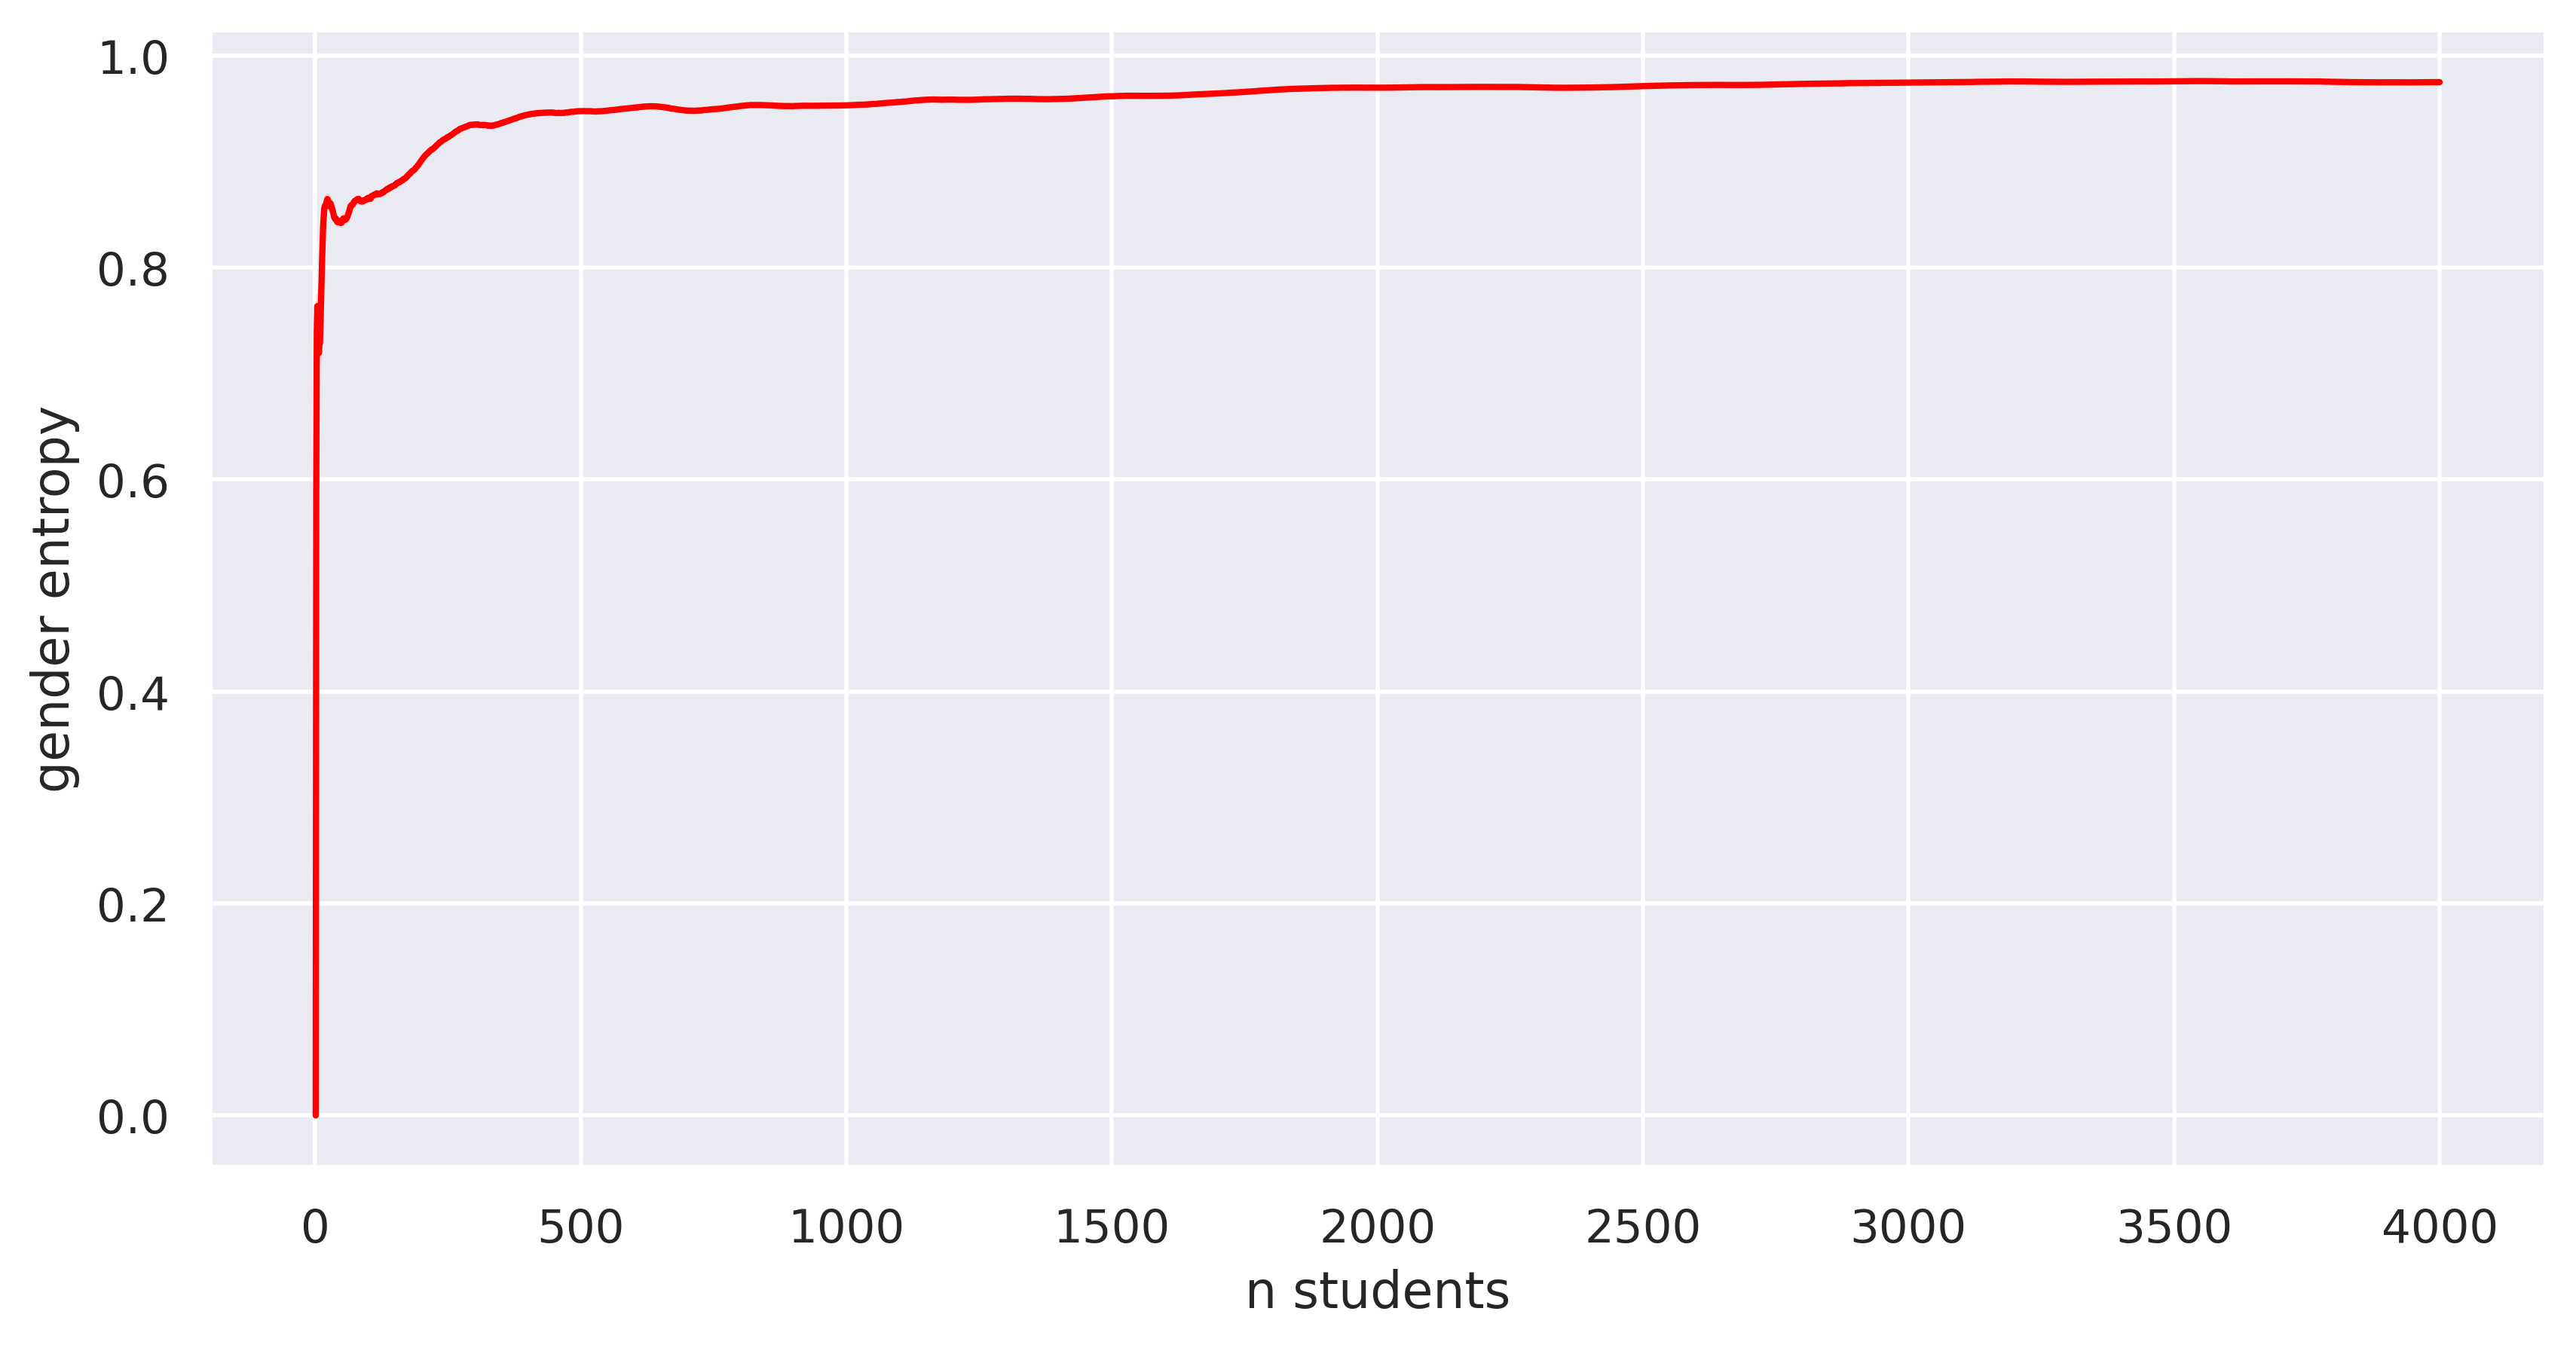

In [7]:
#n students 
df_sort_BIG_mean["n_students"] = range(1,len(df_sort_BIG_mean)+1)

sns.lineplot(data=df_sort_BIG_mean[0:4000], x="n_students", y="entropy_col_GENDER",  color="red", ci="sd")
plt.fill_between("n_students", "lower_std", "upper_std",data=df_sort_BIG_mean[0:500], alpha=0.1, color="red")
plt.xlabel('n students')
plt.ylabel('gender entropy')
plt.show()